# Undiscounted Random Chain, 100 episodes

In [1]:
import glob
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Import Data

In [23]:
in_parent_dir = '../data'
exp_csv_regex = '*10*epis.csv'

exp_csv_pathlist = glob.glob(os.path.join(in_parent_dir, exp_csv_regex))
exp_csv_pathlist

['../data/1003-ex23_SR-trueR_100epis.csv',
 '../data/1003-ex12_lambReturn_100epis.csv',
 '../data/1003-ex24_SRE-SR-combined_5000epis.csv',
 '../data/1003-ex8_SRE-trueSR_10epis.csv',
 '../data/1003-ex1_SRE-learnedSR_10epis.csv',
 '../data/1003-ex19_SRE-learnedSR_100epis.csv']

#### Read all CSVs into single DataFrame

In [24]:
# Read all
exp_df_lists = []
for csv_path in exp_csv_pathlist:
    print('Reading:', csv_path)
    cur_df = pd.read_csv(csv_path, sep='\|\|')
    
    cur_df = cur_df.drop(cur_df.columns[0], axis=1)
    
    exp_df_lists.append(cur_df)

# Concat
data_df = pd.concat(exp_df_lists)

print(len(data_df))
data_df[0:5]

Reading: ../data/1003-ex23_SR-trueR_100epis.csv


/Users/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


Reading: ../data/1003-ex12_lambReturn_100epis.csv
Reading: ../data/1003-ex24_SRE-SR-combined_5000epis.csv
Reading: ../data/1003-ex8_SRE-trueSR_10epis.csv
Reading: ../data/1003-ex1_SRE-learnedSR_10epis.csv
Reading: ../data/1003-ex19_SRE-learnedSR_100epis.csv


/Users/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


2953000


,agentCls_name,cumulative_reward,episode_idx,gamma,lamb,lr,n_states,num_episodes,s_mat_norm,s_mat_rmse,s_subsample_prop,seed,total_steps,use_rand_s_mat,use_true_r_fn,use_true_s_mat,v_vec_avg,v_vec_max,v_vec_min,v_vec_rmse
0,SRAgent,1.0,0,1.0,1.0,0.0001,19,100,None,6.79241,0.05,0,30,False,True,False,5.000000,5.0,5.00000,4.508326
1,SRAgent,1.0,1,1.0,1.0,0.0001,19,100,None,6.79239,0.05,0,114,False,True,False,5.000000,5.0,5.00000,4.508326
2,SRAgent,1.0,2,1.0,1.0,0.0001,19,100,None,6.79236,0.05,0,232,False,True,False,4.999976,5.0,4.99955,4.508304
3,SRAgent,1.0,3,1.0,1.0,0.0001,19,100,None,6.79236,0.05,0,22,False,True,False,4.999976,5.0,4.99955,4.508304
4,SRAgent,1.0,4,1.0,1.0,0.0001,19,100,None,6.79234,0.05,0,102,False,True,False,4.999976,5.0,4.99955,4.508304


In [27]:
set(data_df['agentCls_name'])

{'LambdaAgent', 'SRAgent', 'STraceAgent'}

## Plot parameter sweep
At the 10th episode

Separate the full DataFrame by specific columns 

In [32]:
from itertools import product

def script_get_filtered_indep_dfs():
    Epis_Idx_Filter = 9
    Indep_Cols = ['agentCls_name', 'use_true_s_mat']
    
    
    # ==
    # Filter for specific episode
    epis_data_df = data_df[data_df['episode_idx']==Epis_Idx_Filter]
    
    
    # ==
    # Generate different dataframes

    # Get all the different combinations of independent cols
    indep_col_val_list = []
    for indep_col in Indep_Cols:
        indep_col_val_list.append( list(set(epis_data_df[indep_col].values)) )
    indep_col_val_cartesian_prod = product(*indep_col_val_list)

    # Filter for sub-dataframes, one for each combination
    indep_col_df_dict = {}

    for val_tup in indep_col_val_cartesian_prod:    
        # Filter
        cur_df = epis_data_df.copy(deep=True)
        for i in range(len(Indep_Cols)):
            cur_indep_col = Indep_Cols[i]
            cur_df = cur_df[cur_df[cur_indep_col] == val_tup[i]]

        # Save
        if len(cur_df) > 0:
            cur_comb_name = '_'.join([str(e) for e in list(val_tup)])
            indep_col_df_dict[cur_comb_name] = cur_df

            
    return indep_col_df_dict
    


IndepCols_Dfs_Dict = script_get_filtered_indep_dfs()

for k in IndepCols_Dfs_Dict:
    print(k, len(IndepCols_Dfs_Dict[k]))

STraceAgent_False 13650
STraceAgent_True 7650
LambdaAgent_False 6300
SRAgent_False 1000


#### Plot parameter sweep

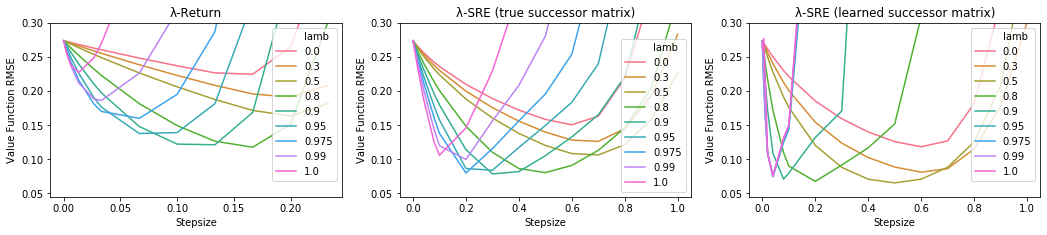

In [37]:
def script_plot_param_sweep(in_Df_dict):
    keys_2_plot = ['LambdaAgent_False', 'STraceAgent_True', 'STraceAgent_False']
    titles_2_plot = ['λ-Return', 'λ-SRE (true successor matrix)', 'λ-SRE (learned successor matrix)']

    # ==
    # Specify plots
    plot_x = 'lr'
    plot_y = 'v_vec_rmse'
    plot_hue = 'lamb'
    plot_ci = None  # Estimator, [None, 'sd']
    
    # ==
    # Copy the right dataframes
    indep_col_df_dict = {
        k:in_Df_dict[k].copy(deep=True) for k in in_Df_dict
    }

    
    # ==
    # Plot

    plt.figure(figsize=(24, 3.2))

    # Generate subplots
    total_n_plots = len(indep_col_df_dict)
    n_plot_counter = 1
    for i in range(len(keys_2_plot)):
        cur_k = keys_2_plot[i]
        # Current
        cur_df = indep_col_df_dict[cur_k]

        # Generate palette
        n_hues = len(set(cur_df[plot_hue].values))
        c_palette = sns.color_palette("husl", n_hues)

        # Plot
        plt.subplot(1, total_n_plots, n_plot_counter)
        sns.lineplot(x=plot_x, y=plot_y, hue=plot_hue, 
                     ci=plot_ci, 
                     palette = c_palette,
                     data=cur_df)


        plt.ylim([0.045, 0.3])
        plt.ylabel('Value Function RMSE')
        plt.xlabel('Stepsize')
        plt.title(titles_2_plot[i])
        #plt.xlim([0,1])

        # Counter var
        n_plot_counter += 1
        

script_plot_param_sweep(IndepCols_Dfs_Dict)

Plotting the same as above but bigger plot

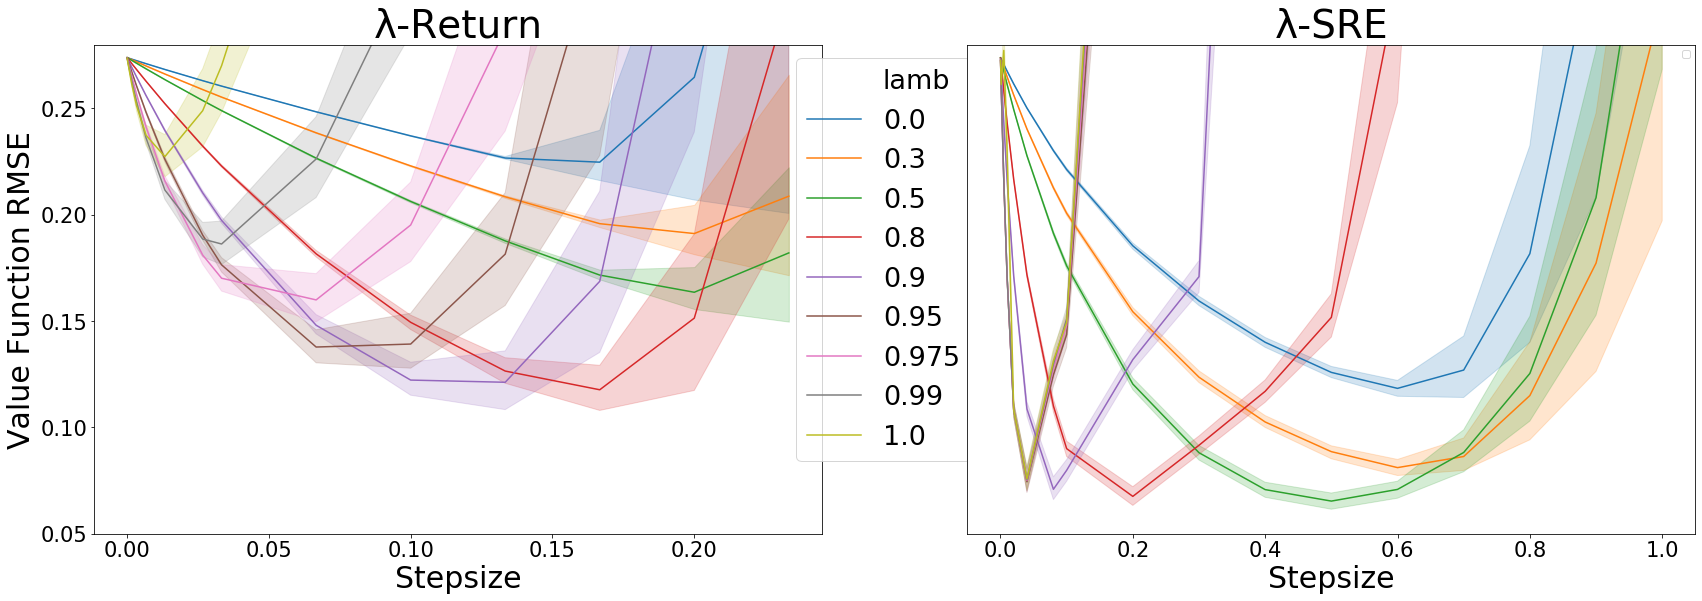

In [157]:
def script_plot_param_sweep(in_Df_dict):
    keys_2_plot = ['LambdaAgent_False', 'STraceAgent_False']
    titles_2_plot = ['λ-Return', 'λ-SRE']

    # ==
    # Specify plots
    plot_x = 'lr'
    plot_y = 'v_vec_rmse'
    plot_hue = 'lamb'
    plot_ci = 95 # 95  # Estimator, [None, 'sd']
    plt_n_boot = 500 # 200
    
    # ==
    # Copy the right dataframes
    indep_col_df_dict = {
        k:in_Df_dict[k].copy(deep=True) for k in in_Df_dict
    }

    
    # ==
    # Plot

    plt.figure(figsize=(60, 9))
    plt_fontsize = 30

    # Generate subplots
    total_n_plots = len(indep_col_df_dict)
    n_plot_counter = 1
    for i in range(len(keys_2_plot)):
        cur_k = keys_2_plot[i]
        # Current
        cur_df = indep_col_df_dict[cur_k]

        # Generate palette
        n_hues = len(set(cur_df[plot_hue].values))
        c_palette = sns.color_palette("tab10", n_hues)

        # Plot
        plt.subplot(1, total_n_plots, n_plot_counter)
        sns.lineplot(x=plot_x, y=plot_y, hue=plot_hue, 
                     ci=plot_ci, 
                     n_boot=plt_n_boot,
                     palette = c_palette,
                     data=cur_df)

        plt.ylim([0.05, 0.28])
        
        plt.title(titles_2_plot[i], fontsize=(plt_fontsize*1.3))
        plt.xlabel('Stepsize', fontsize=plt_fontsize)
        
        if i == 0:
            plt.ylabel('Value Function RMSE', fontsize=plt_fontsize)
            plt.legend(loc='upper right',
                       bbox_to_anchor=(1.223, 1),
                       fontsize=(plt_fontsize*0.9))
            plt.yticks(fontsize=(plt_fontsize*0.7))
        else:
            plt.ylabel('')
            plt.legend([])
            plt.yticks([])
            
        
        plt.xticks(fontsize=(plt_fontsize*0.7))
        
        

        # Counter var
        n_plot_counter += 1
        

script_plot_param_sweep(IndepCols_Dfs_Dict)

## Plot loss over episodes

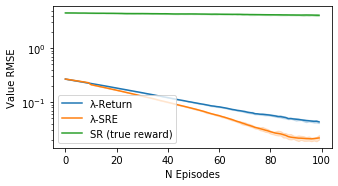

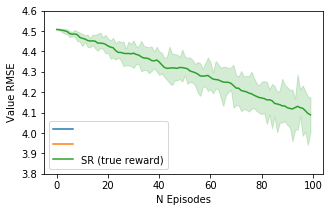

In [76]:
def script_plot_runs_of_all_algos(cur_Data_Df):
    plt_ci = 95
    plt_n_boot = 20 # 200
    
    # ==
    # Filter for dataframe cur_Data_Df
    cur_df = cur_Data_Df.copy(deep=True)

    # Make the Lambda return agent
    cur_df1 = cur_df[cur_df['agentCls_name']=='LambdaAgent']
    cur_df1 = cur_df1[cur_df1['lamb'] == 0.5]
    cur_df1 = cur_df1[cur_df1['lr'] == 0.06666666666666668]

    # Make the STrace agent dataframe
    cur_df2 = cur_df[cur_df['agentCls_name']=='STraceAgent']
    cur_df2 = cur_df2[cur_df2['lamb'] == 0.8]
    cur_df2 = cur_df2[cur_df2['lr'] == 0.02]

    # Make the SR agent dataframe
    cur_df3 = cur_df[cur_df['agentCls_name']=='SRAgent']
    cur_df3 = cur_df3[cur_df3['lr'] == 0.8]


    # ==
    # Generate plots

    plt.figure(figsize=(5,2.6))

    sns.lineplot(x='episode_idx', y='v_vec_rmse', ci=plt_ci, n_boot=plt_n_boot, data=cur_df1)
    sns.lineplot(x='episode_idx', y='v_vec_rmse', ci=plt_ci, n_boot=plt_n_boot, data=cur_df2)
    sns.lineplot(x='episode_idx', y='v_vec_rmse', ci=plt_ci, n_boot=plt_n_boot, data=cur_df3)

    #plt.ylim([-0.01, 0.28])
    plt.yscale('log')
    plt.legend(['λ-Return', 'λ-SRE','SR (true reward)'], loc=3)
    plt.ylabel('Value RMSE')
    plt.xlabel('N Episodes')

    plt.plot()



    plt.figure(figsize=(5,3))

    sns.lineplot(x='episode_idx', y='v_vec_rmse', ci=plt_ci, n_boot=1, data=cur_df1)
    sns.lineplot(x='episode_idx', y='v_vec_rmse', ci=plt_ci, n_boot=1, data=cur_df2)
    sns.lineplot(x='episode_idx', y='v_vec_rmse', ci=plt_ci, n_boot=plt_n_boot, data=cur_df3)

    plt.legend(['', '', 'SR (true reward)'], loc=3)
    plt.ylim([3.8, 4.6])
    plt.ylabel('Value RMSE')
    plt.xlabel('N Episodes')



    #plt.yscale('log')

    plt.show()

script_plot_runs_of_all_algos(data_df)

Bigger plot

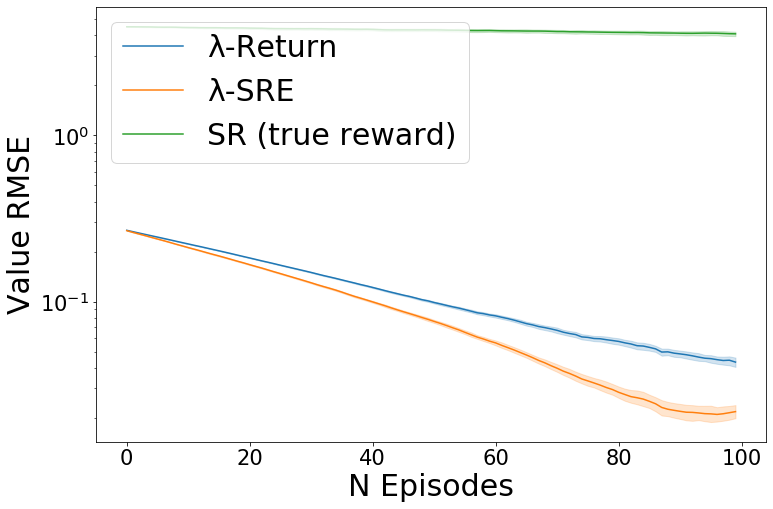

In [158]:
def script_big_all_algos_plot(cur_Data_Df):
    plt_ci = 95  #95
    plt_n_boot = 500 # 200
    
    plt_size = (12,8)
    plt_fontsize = 30
    
    
    # ==
    # Filter for dataframe cur_Data_Df
    cur_df = cur_Data_Df.copy(deep=True)
    cur_df = cur_df[cur_df['use_true_s_mat']==False]    

    # Make the Lambda return agent
    cur_df1 = cur_df[cur_df['agentCls_name']=='LambdaAgent']
    cur_df1 = cur_df1[cur_df1['lamb'] == 0.5]
    cur_df1 = cur_df1[cur_df1['lr'] == 0.06666666666666668]

    # Make the STrace agent dataframe
    cur_df2 = cur_df[cur_df['agentCls_name']=='STraceAgent']
    cur_df2 = cur_df2[cur_df2['lamb'] == 0.8]
    cur_df2 = cur_df2[cur_df2['lr'] == 0.02]

    # Make the SR agent dataframe
    cur_df3 = cur_df[cur_df['agentCls_name']=='SRAgent']
    cur_df3 = cur_df3[cur_df3['lr'] == 0.8]
    
    
    # ==
    # Generate plots

    plt.figure(figsize=plt_size)

    sns.lineplot(x='episode_idx', y='v_vec_rmse', 
                 ci=plt_ci, n_boot=plt_n_boot, data=cur_df1)
    sns.lineplot(x='episode_idx', y='v_vec_rmse', 
                 ci=plt_ci, n_boot=plt_n_boot, data=cur_df2)
    sns.lineplot(x='episode_idx', y='v_vec_rmse', 
                 ci=plt_ci, n_boot=plt_n_boot, data=cur_df3)

    #plt.ylim([-0.01, 0.28])
    plt.yscale('log')
    plt.legend(['λ-Return', 'λ-SRE','SR (true reward)'], 
               loc='upper left', fontsize=plt_fontsize)
    plt.ylabel('Value RMSE', fontsize=plt_fontsize)
    plt.xlabel('N Episodes', fontsize=plt_fontsize)
    
    plt.xticks(fontsize=(plt_fontsize*0.7))
    plt.yticks(fontsize=(plt_fontsize*0.7))

    plt.plot()

    
script_big_all_algos_plot(data_df)

## Plot SR for the 19-state chain

In [126]:
def get_19c_P(n_states=5):    
    pMat = np.zeros((n_states+2, n_states+2))
    
    for i in range(1, (n_states+1)):
        pMat[i, i-1] = 0.5
        pMat[i, i+1] = 0.5
    
    return pMat

def get_sr_mat(trans_mat):
    gamma = 1.0
    n_s = np.shape(trans_mat)[0]
    
    cMat = np.identity(n_s) - (gamma * trans_mat)
    return np.linalg.inv(cMat)
    

pMat = get_19c_P(n_states=19)
print(np.shape(pMat))

srMat = get_sr_mat(pMat)
print(np.shape(srMat))

(21, 21)
(21, 21)


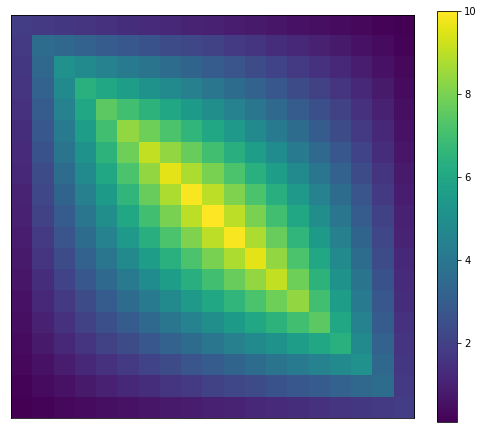

In [156]:
def script_plot_mat(mat):
    plt_fontsize=24
    plt.figure(figsize=(8,8))
    
    n_s = np.shape(mat)[0]
    
    plt_mat = mat[1:-1, 1:-1]
    
    plt.imshow(plt_mat)
    #plt.title('Successor Representation Matrix', fontsize=plt_fontsize)
    plt.xticks([])
    plt.yticks([])
    
    plt.colorbar(fraction=0.046)
    plt.show()
    
script_plot_mat(srMat)